#### Plottear $\int \omega(\theta)d\theta$ vs $K_{mag}$ de datos y muestra control, mismo bineado en cada muestra

In [ ]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue, get_xibs
import configparser

"""
Read config file
"""
print('Reading files')

config = configparser.ConfigParser()
config.read('cross+int.ini')

minsep = config.getfloat('Parameters','minsep')      # Min theta
maxsep = config.getfloat('Parameters','maxsep')      # Max theta
nbins = config.getint('Parameters','nbins')          # Bins in theta
nmult = config.getint('Parameters','nmult')          # nmult := Nr/Nd
nbootstrap = config.getint('Parameters','nbootstrap')# No. of bootstrap resampling
brute = config.getboolean('Parameters','brute')      # Brute force for TreeCorr
nquant = config.getint('Parameters','nquant')        # No. of quantiles to split sample in Mag_K
cutoff = config.getint('Parameters','cutoff')        # Ignore the 'cutoff' no. of last bins for integration

#seed1 = 12936
#seed2 = 19284

sample = config.get('Parameters','sample')
write = config.getboolean('Parameters','write')
corrplot = config.getboolean('Parameters','corrplot')
ratioplot = config.getboolean('Parameters','ratioplot')
treecorr_config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            }

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if sample=='passivecrop': filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
elif sample=='sinAGNWISE': filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISE.txt'
elif sample=='sinAGNWISEniBPT': filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT.txt'
elif sample=='control': filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
print('Sample file:',filename_g)
gxs = ascii.read(filename_g)

# Cut in velocity
gxs = gxs[gxs['cz']>1000.]


# Bright/Faint
quantiles = np.quantile(gxs['K_abs'],np.linspace(0,1,nquant+1))

data = []

for q in range(nquant):
  data.append(

    gxs[(gxs['K_abs']>quantiles[q])&(gxs['K_abs']<quantiles[q+1])]

  )

if corrplot==True:
    corrplotname = f'../plots/cross_treecorr_nq{nquant}_nmult{nmult}_nbs{nbootstrap}'
    corrplotname += f'_{sample}'
    corrplotname += '.png'
    print('Save correlation plots to:',corrplotname)
if ratioplot==True:    
    ratioplotname = f'int_L_nquant{nquant}_nbs{nbootstrap}_{sample}_noRatio.png'
    print('Save ratio plot to:',ratioplotname)
if write==True:
    filename = f'../data/int_L_nq{nquant}_nbs{nbootstrap}_{sample}_noRatio.npz'
    print('Save results to:',filename)

"""
CALCULATIONS
"""
print('Calculating crosscorrelations')
import treecorr

# TreeCorr Catalogues
ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg')

rcat = []
for q in range(nquant):
    rand_ra, rand_dec = generate_RandomCatalogue(data[q]['_RAJ2000'],data[q]['_DEJ2000'],\
                                               nmult, mask=True)
    rcat.append(treecorr.Catalog(ra=rand_ra, dec=rand_dec, \
                        ra_units='deg', dec_units='deg'))

xi_bs = []
varxi_bs = []
for q in range(nquant):
    results =  get_xibs(data[q],nbootstrap,nbins,rcat[q],ecat,treecorr_config) 
    xi_bs.append(results[0])
    varxi_bs.append(results[1])
    print(q+1,'/',nquant)
th = results[2]

"""
Corr PLOT
"""
if corrplot==True:

    print('Plotting correlations')

    import matplotlib.pyplot as plt
    from matplotlib.ticker import FormatStrFormatter

    fig, ax = plt.subplots()

    ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)
    fillalpha=.2
    xi1_max = [np.max(xi_bs[0][:,i]) for i in range(nbins)][:-cutoff]
    ax.fill_between(th[:-cutoff], y1=np.max(xi1_max), color='k', alpha=fillalpha)

    alpha=.2
    capsize = 2
    labels = []
    for q in range(nquant):
        labels.append(
            f'{quantiles[q]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[q+1]:.1f}'
        )

    c = ['C00','C01','C02','C03','C04','C05']
    for q in range(nquant):
        for i in range(nbootstrap):
            line = ax.errorbar(th, xi_bs[q][i], yerr=np.sqrt(varxi_bs[q][i]), \
                        color=c[q], label=labels[q],\
                        alpha=alpha, capsize=capsize)

    #Legend
    handles = [plt.errorbar([],[],yerr=1,color=c[i]) for i in range(nquant)]#,\
    handles.append(plt.fill_between([],[],color='k',alpha=fillalpha))
    labels_ = [labels[i] for i in range(nquant)]
    labels_.append('Integration range')
    plt.legend(handles, labels_, loc=1, fancybox=True, framealpha=0.5, ncol=1)


    ax.set_xlabel(r'$\theta$ (degrees)')
    ax.set_ylabel(r'$\omega(\theta)$')

    ax.set_xlim([minsep,maxsep])

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.savefig(corrplotname)

    #plt.show()
    #plt.close()

"""
INTEGRATION
"""
print('Integration')


from scipy import integrate, stats

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        int[q][i] = integrate.trapezoid(th[:-cutoff] * xi_bs[q][i][:-cutoff],x=th[:-cutoff])
    

ratio_mean = np.zeros(nquant)
std_mean = np.zeros(nquant)
int_mean = np.zeros(nquant)
int_std = np.zeros(nquant)


for q in range(nquant):
    int_mean[q] = np.mean(int[q])
    int_std[q] = np.std(int[q])
    ratio_mean[q] = np.mean(int[q])/np.mean(int[0])
    std_mean[q] = np.std(int[q])/np.mean(int[0])

"""
RATIO PLOTS
"""
if ratioplot==True:
    print('Plotting ratios')

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()

    meanMag = np.zeros(nquant)
    for q in range(nquant):
        meanMag[q] = np.mean(data[q]['K_abs'])

    res = stats.linregress(-meanMag, int_mean)
    print(f"R-squared: {res.rvalue**2:.3f}")

    fig, ax = plt.subplots()
    ax.plot(-meanMag, res.intercept - res.slope*meanMag, 'r:',\
            label='Linear regression; '+r'$R^2=$'+f'{res.rvalue**2:.2f}')
    
    for i in range(len(ratio_mean)):
        ax.errorbar(-meanMag[i],int_mean[i],yerr=int_std[i],c='C00',fmt='o')
    #ax.axline((1,1),slope=1,c='k',ls=':')
    ax.set_ylabel(r'$<\int\omega_Nd\theta>$')
    ax.set_xlabel(r'$-K_{\mathrm{abs}}$')

    ax.legend(loc=4)

    plt.savefig('../plots/'+ratioplotname)

    #plt.show()
    #plt.close()


if write==True:

    names = ['int_mean','meanMag','int_std']

    print('Writing results in:', filename)
    ascii.write(np.column_stack([int_mean,meanMag,int_std]),filename,names=names,overwrite=True)




#### Rewrite with DeepSeek

Reading files
Sample file: ../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt
Save correlation plots to: ../plots/cross_treecorr_nq3_nmult80_nbs100_control.png
Save ratio plot to: int_L_nquant3_nbs100_control_noRatio.png
Save results to: ../data/int_L_nq3_nbs100_control_noRatio.npz
Calculating crosscorrelations
1/3
2/3
3/3
Plotting correlations
Integration
Plotting ratios
R-squared: 0.857
Writing results in: ../data/int_L_nq3_nbs100_control_noRatio.npz


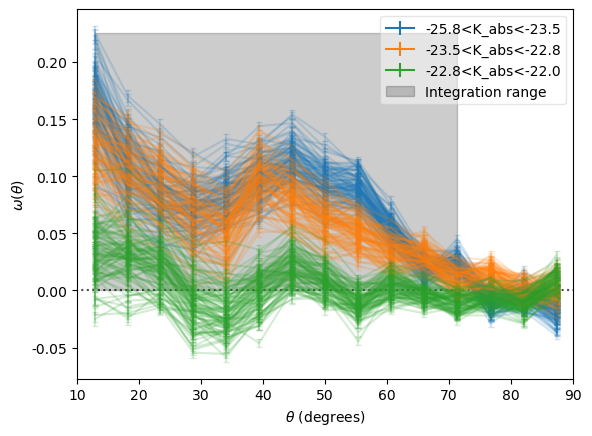

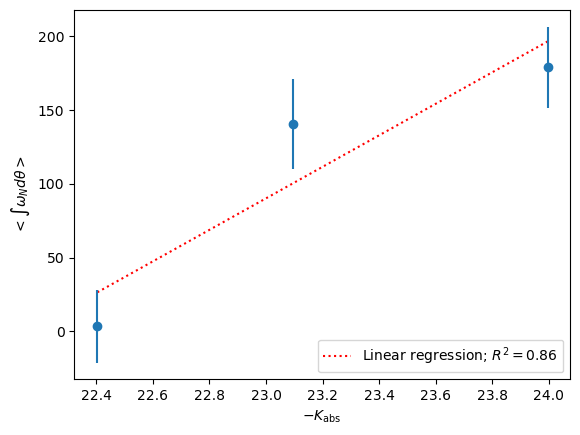

In [1]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue, get_xibs
import configparser
import treecorr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate, stats

def read_config(config_file):
    """Read and parse the configuration file."""
    config = configparser.ConfigParser()
    config.read(config_file)
    params = {
        'minsep': config.getfloat('Parameters', 'minsep'),
        'maxsep': config.getfloat('Parameters', 'maxsep'),
        'nbins': config.getint('Parameters', 'nbins'),
        'nmult': config.getint('Parameters', 'nmult'),
        'nbootstrap': config.getint('Parameters', 'nbootstrap'),
        'brute': config.getboolean('Parameters', 'brute'),
        'nquant': config.getint('Parameters', 'nquant'),
        'cutoff': config.getint('Parameters', 'cutoff'),
        'sample': config.get('Parameters', 'sample'),
        'write': config.getboolean('Parameters', 'write'),
        'corrplot': config.getboolean('Parameters', 'corrplot'),
        'ratioplot': config.getboolean('Parameters', 'ratioplot')
    }
    return params

def load_data(sample):
    """Load data based on the sample type."""
    if sample == 'passivecrop':
        filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
    elif sample == 'sinAGNWISE':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISE.txt'
    elif sample == 'sinAGNWISEniBPT':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT.txt'
    elif sample == 'control':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
    else:
        filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
    print(f'Sample file: {filename_g}')
    return ascii.read(filename_g)

def main():
    print('Reading files')
    params = read_config('cross+int.ini')
    treecorr_config = {
        "min_sep": params['minsep'],
        "max_sep": params['maxsep'],
        "nbins": params['nbins'],
        "sep_units": 'degree',
        "bin_type": 'Linear',
        "brute": params['brute'],
        "metric": 'Arc'
    }

    # Read UHECR data
    events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
    eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
    mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
    events_a8 = events_a8[mask_eve]

    # Read galaxy data
    gxs = load_data(params['sample'])
    gxs = gxs[gxs['cz'] > 1000.]

    # Split data into quantiles
    quantiles = np.quantile(gxs['K_abs'], np.linspace(0, 1, params['nquant'] + 1))
    data = [gxs[(gxs['K_abs'] > quantiles[q]) & (gxs['K_abs'] < quantiles[q + 1])] for q in range(params['nquant'])]

    if params['corrplot']:
        corrplotname = f'../plots/cross_treecorr_nq{params["nquant"]}_nmult{params["nmult"]}_nbs{params["nbootstrap"]}_{params["sample"]}.png'
        print(f'Save correlation plots to: {corrplotname}')
    if params['ratioplot']:
        ratioplotname = f'int_L_nquant{params["nquant"]}_nbs{params["nbootstrap"]}_{params["sample"]}_noRatio.png'
        print(f'Save ratio plot to: {ratioplotname}')
    if params['write']:
        filename = f'../data/int_L_nq{params["nquant"]}_nbs{params["nbootstrap"]}_{params["sample"]}_noRatio.npz'
        print(f'Save results to: {filename}')

    print('Calculating crosscorrelations')
    ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], ra_units='deg', dec_units='deg')
    #seeds = np.linspace(1000,1+params['nquant']-1,params['nquant'],dtype=int)
    rcat = [treecorr.Catalog(ra=generate_RandomCatalogue(data[q]['_RAJ2000'], data[q]['_DEJ2000'], params['nmult'], seed=None,mask=True)[0],
            dec=generate_RandomCatalogue(data[q]['_RAJ2000'], data[q]['_DEJ2000'], params['nmult'], seed=None, mask=True)[1],
            ra_units='deg', dec_units='deg') for q in range(params['nquant'])]

    xi_bs, varxi_bs = [], []
    for q in range(params['nquant']):
        results = get_xibs(data[q], params['nbootstrap'], params['nbins'], rcat[q], ecat, treecorr_config)
        xi_bs.append(results[0])
        varxi_bs.append(results[1])
        print(f'{q + 1}/{params["nquant"]}')
    th = results[2]

    if params['corrplot']:
        print('Plotting correlations')
        fig, ax = plt.subplots()
        ax.hlines(0., 0., 90., ls=':', color='k', alpha=.7)
        fillalpha = .2
        xi1_max = [np.max(xi_bs[0][:, i]) for i in range(params['nbins'])][:-params['cutoff']]
        ax.fill_between(th[:-params['cutoff']], y1=np.max(xi1_max), color='k', alpha=fillalpha)

        alpha, capsize = .2, 2
        labels = [f'{quantiles[q]:.1f}<K_abs<{quantiles[q + 1]:.1f}' for q in range(params['nquant'])]
        colors = ['C00', 'C01', 'C02', 'C03', 'C04', 'C05']
        for q in range(params['nquant']):
            for i in range(params['nbootstrap']):
                ax.errorbar(th, xi_bs[q][i], yerr=np.sqrt(varxi_bs[q][i]), color=colors[q], label=labels[q],
                           alpha=alpha, capsize=capsize)

        handles = [plt.errorbar([], [], yerr=1, color=colors[i]) for i in range(params['nquant'])]
        handles.append(plt.fill_between([], [], color='k', alpha=fillalpha))
        labels_ = labels + ['Integration range']
        ax.legend(handles, labels_, loc=1, fancybox=True, framealpha=0.5, ncol=1)

        ax.set_xlabel(r'$\theta$ (degrees)')
        ax.set_ylabel(r'$\omega(\theta)$')
        ax.set_xlim([params['minsep'], params['maxsep']])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.savefig(corrplotname)

    print('Integration')
    int_results = [np.zeros(params['nbootstrap']) for _ in range(params['nquant'])]
    for q in range(params['nquant']):
        for i in range(params['nbootstrap']):
            int_results[q][i] = integrate.trapezoid(th[:-params['cutoff']] * xi_bs[q][i][:-params['cutoff']], x=th[:-params['cutoff']])

    int_mean = np.array([np.mean(int_results[q]) for q in range(params['nquant'])])
    int_std = np.array([np.std(int_results[q]) for q in range(params['nquant'])])
    #ratio_mean = int_mean / int_mean[0]
    #std_mean = int_std / int_mean[0]

    if params['ratioplot']:
        print('Plotting ratios')
        mean_mag = np.array([np.mean(data[q]['K_abs']) for q in range(params['nquant'])])
        res = stats.linregress(-mean_mag, int_mean)
        print(f"R-squared: {res.rvalue**2:.3f}")

        fig, ax = plt.subplots()
        ax.plot(-mean_mag, res.intercept - res.slope * mean_mag, 'r:',
                label=f'Linear regression; $R^2={res.rvalue**2:.2f}$')
        ax.errorbar(-mean_mag, int_mean, yerr=int_std, c='C00', fmt='o')
        ax.set_ylabel(r'$<\int\omega_Nd\theta>$')
        ax.set_xlabel(r'$-K_{\mathrm{abs}}$')
        ax.legend(loc=4)
        plt.savefig(f'../plots/{ratioplotname}')

    if params['write']:
        print(f'Writing results in: {filename}')
        ascii.write(np.column_stack([int_mean, mean_mag, int_std]), filename,
                    names=['int_mean', 'meanMag', 'int_std'], overwrite=True)

if __name__ == "__main__":
    main()

#### Make single plot with all gxs and control gxs

Reading files
Sample file: ../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt
Save correlation plots to: ../plots/cross_treecorr_nq6_nmult100_nbs100_control.png
Save ratio plot to: int_L_nquant6_nbs100_control_noRatio.png
Save results to: ../data/int_L_nq6_nbs100_control_noRatio.npz
Calculating crosscorrelations
1/6
2/6
3/6
4/6
5/6
6/6
Plotting correlations for control
Integration
Plotting ratios
R-squared: 0.010
Writing results in: ../data/int_L_nq6_nbs100_control_noRatio.npz


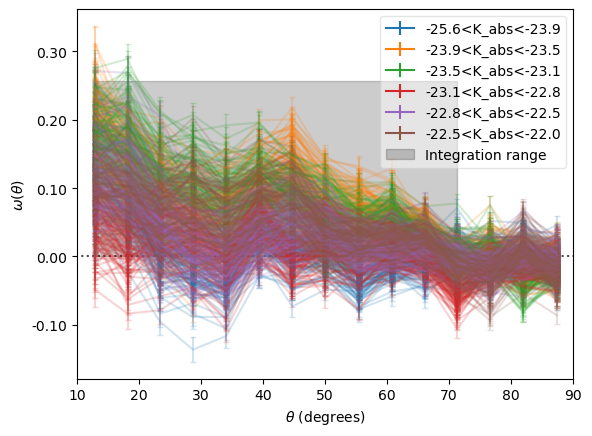

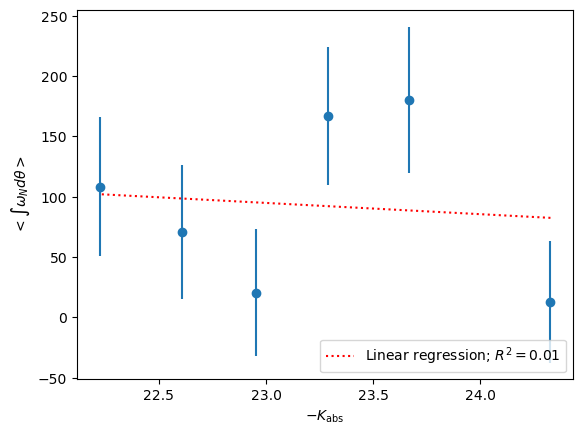

In [ ]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue, get_xibs
import configparser
import treecorr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate, stats

def read_config(config_file):
    """Read and parse the configuration file."""
    config = configparser.ConfigParser()
    config.read(config_file)
    params = {
        'minsep': config.getfloat('Parameters', 'minsep'),
        'maxsep': config.getfloat('Parameters', 'maxsep'),
        'nbins': config.getint('Parameters', 'nbins'),
        'nmult': config.getint('Parameters', 'nmult'),
        'nbootstrap': config.getint('Parameters', 'nbootstrap'),
        'brute': config.getboolean('Parameters', 'brute'),
        'nquant': config.getint('Parameters', 'nquant'),
        'cutoff': config.getint('Parameters', 'cutoff'),
        'sample': config.get('Parameters', 'sample'),
        'write': config.getboolean('Parameters', 'write'),
        'corrplot': config.getboolean('Parameters', 'corrplot'),
        'ratioplot': config.getboolean('Parameters', 'ratioplot'),
        'gclass': config.getint('Parameters', 'gclass')
    }
    return params

def load_data(sample):
    """Load data based on the sample type."""
    if sample == 'passivecrop':
        filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
    elif sample == 'sinAGNWISE':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISE.txt'
    elif sample == 'sinAGNWISEniBPT':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT.txt'
    elif sample == 'control':
        filename_g = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
    else:
        filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
    print(f'Sample file: {filename_g}')
    return ascii.read(filename_g)

def main():
    from scipy import stats

    print('Reading files')
    params = read_config('cross+int.ini')
    treecorr_config = {
        "min_sep": params['minsep'],
        "max_sep": params['maxsep'],
        "nbins": params['nbins'],
        "sep_units": 'degree',
        "bin_type": 'Linear',
        "brute": params['brute'],
        "metric": 'Arc'
    }

    # Read UHECR data
    events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
    eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
    mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
    events_a8 = events_a8[mask_eve]

    # Read galaxy data
    gxs = load_data(params['sample'])
    gxs = gxs[gxs['cz'] > 1000.]
    if params['sample']=='control':
        gxs = gxs[gxs['class']==params['gclass']]
        #gxs_ps = gxs_all[gxs_all['class']==3]

    # Split data into quantiles
    quantiles = np.quantile(gxs['K_abs'], np.linspace(0, 1, params['nquant'] + 1))

    # Make calculations+plots for both samples
    #for gxs, sample in zip([gxs_all], ['All']):

    #quantiles = np.quantile(data['K_abs'], np.linspace(0, 1, params['nquant'] + 1))

    data = [gxs[(gxs['K_abs'] > quantiles[q]) & (gxs['K_abs'] < quantiles[q + 1])] for q in range(params['nquant'])]

    if params['corrplot']:
        corrplotname = f'../plots/cross_treecorr_nq{params["nquant"]}_nmult{params["nmult"]}_nbs{params["nbootstrap"]}_{params['sample']}.png'
        print(f'Save correlation plots to: {corrplotname}')
    if params['ratioplot']:
        ratioplotname = f'int_L_nquant{params["nquant"]}_nbs{params["nbootstrap"]}_{params['sample']}_noRatio.png'
        print(f'Save ratio plot to: {ratioplotname}')
    if params['write']:
        filename = f'../data/int_L_nq{params["nquant"]}_nbs{params["nbootstrap"]}_{params['sample']}_noRatio.npz'
        print(f'Save results to: {filename}')

    print('Calculating crosscorrelations')
    ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], ra_units='deg', dec_units='deg')
    rcat = [treecorr.Catalog(ra=generate_RandomCatalogue(data[q]['_RAJ2000'], data[q]['_DEJ2000'], params['nmult'], mask=True)[0],
            dec=generate_RandomCatalogue(data[q]['_RAJ2000'], data[q]['_DEJ2000'], params['nmult'], mask=True)[1],
            ra_units='deg', dec_units='deg') for q in range(params['nquant'])]

    xi_bs, varxi_bs = [], []
    for q in range(params['nquant']):
        results = get_xibs(data[q], params['nbootstrap'], params['nbins'], rcat[q], ecat, treecorr_config)
        xi_bs.append(results[0])
        varxi_bs.append(results[1])
        print(f'{q + 1}/{params["nquant"]}')
    th = results[2]

    if params['corrplot']:
        print('Plotting correlations for', params['sample'])
        fig, ax = plt.subplots()
        ax.hlines(0., 0., 90., ls=':', color='k', alpha=.7)
        fillalpha = .2
        xi1_max = [np.max(xi_bs[0][:, i]) for i in range(params['nbins'])][:-params['cutoff']]
        ax.fill_between(th[:-params['cutoff']], y1=np.max(xi1_max), color='k', alpha=fillalpha)

        alpha, capsize = .2, 2
        labels = [f'{quantiles[q]:.1f}<K_abs<{quantiles[q + 1]:.1f}' for q in range(params['nquant'])]
        colors = ['C00', 'C01', 'C02', 'C03', 'C04', 'C05']
        for q in range(params['nquant']):
            for i in range(params['nbootstrap']):
                ax.errorbar(th, xi_bs[q][i], yerr=np.sqrt(varxi_bs[q][i]), color=colors[q], label=labels[q],
                        alpha=alpha, capsize=capsize)

        handles = [plt.errorbar([], [], yerr=1, color=colors[i]) for i in range(params['nquant'])]
        handles.append(plt.fill_between([], [], color='k', alpha=fillalpha))
        labels_ = labels + ['Integration range']
        ax.legend(handles, labels_, loc=1, fancybox=True, framealpha=0.5, ncol=1)

        ax.set_xlabel(r'$\theta$ (degrees)')
        ax.set_ylabel(r'$\omega(\theta)$')
        ax.set_xlim([params['minsep'], params['maxsep']])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.savefig(corrplotname)

    print('Integration')
    int_results = [np.zeros(params['nbootstrap']) for _ in range(params['nquant'])]
    for q in range(params['nquant']):
        for i in range(params['nbootstrap']):
            int_results[q][i] = integrate.trapezoid(th[:-params['cutoff']] * xi_bs[q][i][:-params['cutoff']], x=th[:-params['cutoff']])

    int_mean = np.array([np.mean(int_results[q]) for q in range(params['nquant'])])
    int_std = np.array([np.std(int_results[q]) for q in range(params['nquant'])])

    if params['ratioplot']:
        print('Plotting ratios')
        mean_mag = np.array([np.mean(data[q]['K_abs']) for q in range(params['nquant'])])
        res = stats.linregress(-mean_mag, int_mean)
        print(f"R-squared: {res.rvalue**2:.3f}")

        fig, ax = plt.subplots()
        ax.plot(-mean_mag, res.intercept - res.slope * mean_mag, 'r:',
                label=f'Linear regression; $R^2={res.rvalue**2:.2f}$')
        ax.errorbar(-mean_mag, int_mean, yerr=int_std, c='C00', fmt='o')
        ax.set_ylabel(r'$<\int\omega_Nd\theta>$')
        ax.set_xlabel(r'$-K_{\mathrm{abs}}$')
        ax.legend(loc=4)
        plt.savefig(f'../plots/{ratioplotname}')

    if params['write']:
        print(f'Writing results in: {filename}')
        ascii.write(np.column_stack([int_mean, mean_mag, int_std]), filename,
                    names=['int_mean', 'meanMag', 'int_std'], overwrite=True)


    # # Both samples in a plot

    # fig, ax = plt.subplots()

    # for sample, color in zip(['All'],['C00']):

    #     filename = f'../data/int_L_nq{params['nquant']}_nbs{params['nbootstrap']}_{sample}_noRatio.npz'

    #     data = ascii.read(filename)

    #     from scipy import stats

    #     meanMag = data['meanMag']
    #     int_mean = data['int_mean']
    #     int_std = data['int_std']

    #     res = stats.linregress(-meanMag, int_mean)
    #     print(f"R-squared: {res.rvalue**2:.3f}")

    #     ax.plot(-meanMag, res.intercept - res.slope*meanMag, ls=':',c=color,\
    #             label=f'{sample}; '+r'$R^2=$'+f'{res.rvalue**2:.2f}')

    #     for i in range(len(int_mean)):
    #         ax.errorbar(-meanMag[i],int_mean[i],yerr=int_std[i],c=color,fmt='o')


    # ax.set_ylabel(r'$<\int\omega_Nd\theta>$')
    # ax.set_xlabel(r'$-K_{\mathrm{abs}}$')

    # ax.legend(loc=4)

    # #plt.savefig(f'../data/int_L_nq{params['nquant']}_nbs{params['nbootstrap']}_SinAGNWISEniBPT+SF+Passive_noRatio.png')

    # plt.show()


if __name__ == "__main__":
    main()

#### Just Final Plot

R-squared: 0.625
R-squared: 0.775
R-squared: 0.715


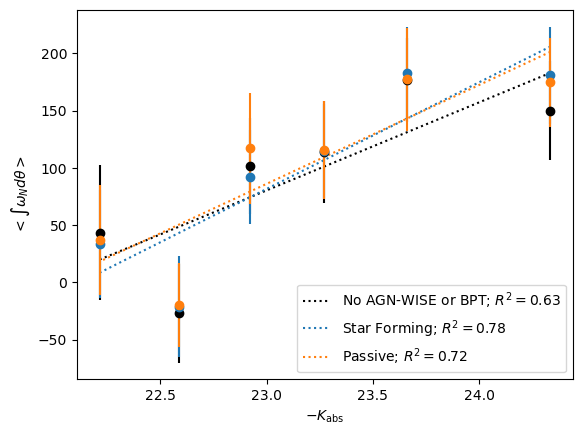

In [14]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
import configparser
import matplotlib.pyplot as plt

def read_config(config_file):
    """Read and parse the configuration file."""
    config = configparser.ConfigParser()
    config.read(config_file)
    params = {
        'minsep': config.getfloat('Parameters', 'minsep'),
        'maxsep': config.getfloat('Parameters', 'maxsep'),
        'nbins': config.getint('Parameters', 'nbins'),
        'nmult': config.getint('Parameters', 'nmult'),
        'nbootstrap': config.getint('Parameters', 'nbootstrap'),
        'brute': config.getboolean('Parameters', 'brute'),
        'nquant': config.getint('Parameters', 'nquant'),
        'cutoff': config.getint('Parameters', 'cutoff'),
        'sample': config.get('Parameters', 'sample'),
        'write': config.getboolean('Parameters', 'write'),
        'corrplot': config.getboolean('Parameters', 'corrplot'),
        'ratioplot': config.getboolean('Parameters', 'ratioplot')
    }
    return params

params = read_config('cross+int.ini')

fig, ax = plt.subplots()

for sample, color in zip(['No AGN-WISE or BPT','Star Forming','Passive'],['k','C00','C01']):

    filename = f'../data/int_L_nq{params['nquant']}_nbs{params['nbootstrap']}_{sample}_noRatio.npz'

    data = ascii.read(filename)

    from scipy import stats

    meanMag = data['meanMag']
    int_mean = data['int_mean']
    int_std = data['int_std']

    res = stats.linregress(-meanMag, int_mean)
    print(f"R-squared: {res.rvalue**2:.3f}")

    ax.plot(-meanMag, res.intercept - res.slope*meanMag, ls=':',c=color,\
            label=f'{sample}; '+r'$R^2=$'+f'{res.rvalue**2:.2f}')

    for i in range(len(int_mean)):
        ax.errorbar(-meanMag[i],int_mean[i],yerr=int_std[i],c=color,fmt='o')


ax.set_ylabel(r'$<\int\omega_Nd\theta>$')
ax.set_xlabel(r'$-K_{\mathrm{abs}}$')

ax.legend(loc=4)

plt.savefig(f'../data/int_L_nq{params['nquant']}_nbs{params['nbootstrap']}_SinAGNWISEniBPT+SF+Passive_noRatio.png')

plt.show()
